In [716]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime, time
from prophet import Prophet
import glob

In [717]:
# obtain and sort required raw data
degree_days = 'gw_hdd'
path = "RawData"

def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time

def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    # date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    # date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime

degree_days = degree_days
ecmwf_files = glob.glob(path + f'/ecmwf.*.[01][02].{degree_days}.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_ens_files = glob.glob(path + f'/ecmwf-eps.*.[01][02].{degree_days}.csv')
ecmwf_ens_sorted_files = sorted(ecmwf_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + f'/gfs-ens-bc.*.[01][02].{degree_days}.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + f'/cmc-ens.*.[01][02].{degree_days}.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_ens_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                              extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_ens_sorted_files = [filename for filename in ecmwf_ens_sorted_files if
                              extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if
                            extract_date_time(filename) in master_set]

### process raw data into individual components for model

In [718]:
# y
# euro ensemble - values to predict
ecmwf_ens_9_14 = pd.DataFrame(columns=['ens(9,14)'])

for i in range(1, len(ecmwf_ens_sorted_files)):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_ens_df, ecmwf_ens_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_ens_df['Value'].iloc[8:14].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(8+offset):(14+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_ens_9_14.columns, index=[date])
    ecmwf_ens_9_14 = pd.concat([ecmwf_ens_9_14, new_row])

In [719]:
# X1
# euro ensemble day 8
ecmwf_ens_8 = pd.DataFrame(columns=['ens(8)'])

for i in range(1, len(ecmwf_ens_sorted_files)):
    ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
    ecmwf_ens_df = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_ens_df, ecmwf_ens_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_ens_df['Value'].iloc[7:8].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(7+offset):(8+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_ens_8.columns, index=[date])
    ecmwf_ens_8 = pd.concat([ecmwf_ens_8, new_row])

In [720]:
# X2
# ecmwf(9,10) - ecmwf_ens-1(9,10)

ecmwf_9_10 = pd.DataFrame(columns=['ecmwf(9,10)'])

for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_df = ecmwf_df[ecmwf_df[ecmwf_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(ecmwf_df, ecmwf_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = ecmwf_df['Value'].iloc[8:10].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(8+offset):(10+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=ecmwf_9_10.columns, index=[date])
    ecmwf_9_10 = pd.concat([ecmwf_9_10, new_row])

In [721]:
# X3
# gfs(11,14) - ecmwf_ens-1(11,14)

gfs_11_14 = pd.DataFrame(columns=['gfs(11,14)'])

for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]
    prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i-1])
    prev_ecmwf_ens_df = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

    date = get_date(gfs_df, gfs_ens_bc_sorted_files[i])
    prev_date = get_date(prev_ecmwf_ens_df, ecmwf_ens_sorted_files[i - 1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 == d1:
        offset = 1
    else:
        offset = 0

    cur = gfs_df['Value'].iloc[10:14].sum()
    prev = prev_ecmwf_ens_df['Value'].iloc[(10+offset):(14+offset)].sum()
    change = cur - prev

    new_row = pd.DataFrame(change, columns=gfs_11_14.columns, index=[date])
    gfs_11_14 = pd.concat([gfs_11_14, new_row])

In [722]:
# X4
# cmc(9,14) - gfs(9,14)

cmc_9_14 = pd.DataFrame(columns=['cmc(9,14)'])

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_df = pd.read_csv(cmc_ens_sorted_files[i])
    cmc_df = cmc_df[cmc_df[cmc_df.columns[2]] >= 1]
    gfs_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    gfs_df = gfs_df[gfs_df[gfs_df.columns[2]] >= 1]

    date = get_date(cmc_df, cmc_ens_sorted_files[i])

    cmc = cmc_df['Value'].iloc[8:14].sum()
    gfs = gfs_df['Value'].iloc[8:14].sum()
    change = cmc - gfs

    new_row = pd.DataFrame(change, columns=cmc_9_14.columns, index=[date])
    cmc_9_14 = pd.concat([cmc_9_14, new_row])

# testing

In [723]:
i = 2

d1 = ecmwf_ens_sorted_files[i].split('.')[1]
d2 = ecmwf_ens_sorted_files[i - 1].split('.')[1]

ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i])
v1 = ecmwf_ens_df[ecmwf_ens_df[ecmwf_ens_df.columns[2]] >= 1]
prev_ecmwf_ens_df = pd.read_csv(ecmwf_ens_sorted_files[i - 1])
v2 = prev_ecmwf_ens_df[prev_ecmwf_ens_df[prev_ecmwf_ens_df.columns[2]] >= 1]

In [724]:
print(ecmwf_ens_sorted_files[i])
print(ecmwf_ens_sorted_files[i - 1])

RawData/ecmwf-eps.20180711.12.gw_hdd.csv
RawData/ecmwf-eps.20180711.00.gw_hdd.csv


In [725]:
if d1 == d2:
    offset = 1
else:
    offset = 0

In [726]:
a = v1.iloc[7:8]

In [727]:
b = v2.iloc[7+offset:8+offset]

In [728]:
a['Value'].sum() - b['Value'].sum()

0.002999999999999999

In [729]:
display(a)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
15,2018-07-19,0.009,1


In [730]:
display(b)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
15,2018-07-19,0.006,1


In [731]:
display(v1)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
8,2018-07-12,0.003,1
9,2018-07-13,0.005,1
10,2018-07-14,0.003,1
11,2018-07-15,0.001,1
12,2018-07-16,0.003,1
13,2018-07-17,0.001,1
14,2018-07-18,0.004,1
15,2018-07-19,0.009,1
16,2018-07-20,0.007,1
17,2018-07-21,0.004,1


In [732]:
display(v2)

,Date,Value,Flag (0=obs 1=fcst 2=norm)
7,2018-07-11,0.007,1
8,2018-07-12,0.002,1
9,2018-07-13,0.005,1
10,2018-07-14,0.004,1
11,2018-07-15,0.002,1
12,2018-07-16,0.004,1
13,2018-07-17,0.002,1
14,2018-07-18,0.004,1
15,2018-07-19,0.006,1
16,2018-07-20,0.004,1


In [733]:
display(ecmwf_ens_8.head())

,ens(8)
2018-07-11 00:00:00,0.002
2018-07-11 12:00:00,0.003
2018-07-12 00:00:00,-0.002
2018-07-12 12:00:00,-0.002
2018-07-13 00:00:00,-0.001


# model

In [737]:
master_df = pd.concat([ecmwf_ens_9_14, ecmwf_ens_8, ecmwf_9_10, gfs_11_14, cmc_9_14], axis=1)

In [740]:
data = master_df.copy()

In [741]:
#get only noon forecast
data['hour'] = data.index.hour
data = data[data['hour'] == 12]
data.drop('hour', axis=1, inplace=True)

In [742]:
display(data.columns)

Index(['ens(9,14)', 'ens(8)', 'ecmwf(9,10)', 'gfs(11,14)', 'cmc(9,14)'], dtype='object')

In [743]:
# betas for hdd
b1 = 0.76947604258751
b2 = 0.6555933110283885
b3 = 0.16964083221789059
b4 = 0.06680336217511197

In [744]:
(b1*0.003) + (b2*0.088) + (b3*0.037) + (b4*-0.040)

0.06360521580331818

In [745]:
X = data[['ens(8)', 'ecmwf(9,10)', 'gfs(11,14)', 'cmc(9,14)']]

In [746]:
X

,ens(8),"ecmwf(9,10)","gfs(11,14)","cmc(9,14)"
2018-07-11 12:00:00,0.003,0.088,0.037,-0.040
2018-07-12 12:00:00,-0.002,0.045,0.036,-0.053
2018-07-13 12:00:00,0.000,0.021,0.028,-0.048
2018-07-14 12:00:00,-0.001,-0.007,0.036,-0.053
2018-07-15 12:00:00,0.000,0.002,0.024,-0.039
...,...,...,...,...
2023-05-12 12:00:00,-1.098,-0.773,0.803,-2.337
2023-05-13 12:00:00,-0.563,0.351,1.843,0.595
2023-05-14 12:00:00,0.210,0.871,1.201,-2.417
2023-05-15 12:00:00,-0.080,2.357,1.071,-2.618


In [747]:
y = data['ens(9,14)']

In [748]:
y

2018-07-11 12:00:00    0.004
2018-07-12 12:00:00    0.001
2018-07-13 12:00:00    0.001
2018-07-14 12:00:00    0.000
2018-07-15 12:00:00    0.012
                       ...  
2023-05-12 12:00:00    0.378
2023-05-13 12:00:00   -0.801
2023-05-14 12:00:00    0.524
2023-05-15 12:00:00    1.045
2023-05-16 12:00:00   -0.083
Name: ens(9,14), Length: 1749, dtype: float64

In [749]:
preds = (b1 * X.iloc[:,0]) + (b2 * X.iloc[:,1]) + (b3 * X.iloc[:,2]) + (b4 * X.iloc[:,3])

In [750]:
preds[0]

0.06360521580331818

In [751]:
mse = mean_squared_error(y, preds)
mse

16.152998744045345

In [752]:
errors = y - preds

In [753]:
errors = errors.to_frame()
errors['ds'] = errors.index
errors.rename(columns={0:'y'}, inplace=True)
errors.reset_index(drop=True, inplace=True)

In [754]:
train_len = 0.85
train_errors = errors.iloc[:int(len(errors)*train_len)]
test_errors = errors.iloc[int(len(errors)*train_len):]

In [755]:
m = Prophet()
m.fit(train_errors)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/depe3hek.json
DEBUG:cmdstanpy:input tempfile: /var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/65htal3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26816', 'data', 'file=/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/depe3hek.json', 'init=/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/65htal3r.json', 'output', 'file=/var/folders/3y/4qthl0m139n7983g0dhsq1n00000gn/T/tmpc8drgg00/prophet_modelwct2iebf/prophet_model-20230620144314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:43:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] star

In [756]:
future = m.make_future_dataframe(periods=263)
future.tail()

,ds
1744,2023-05-12 12:00:00
1745,2023-05-13 12:00:00
1746,2023-05-14 12:00:00
1747,2023-05-15 12:00:00
1748,2023-05-16 12:00:00


In [757]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1744,2023-05-12 12:00:00,-0.405323,-4.827191,3.904478
1745,2023-05-13 12:00:00,-0.446582,-4.921328,4.334308
1746,2023-05-14 12:00:00,-0.133364,-5.191673,4.487091
1747,2023-05-15 12:00:00,0.438097,-4.371860,4.991824
1748,2023-05-16 12:00:00,0.001857,-4.509302,4.662217


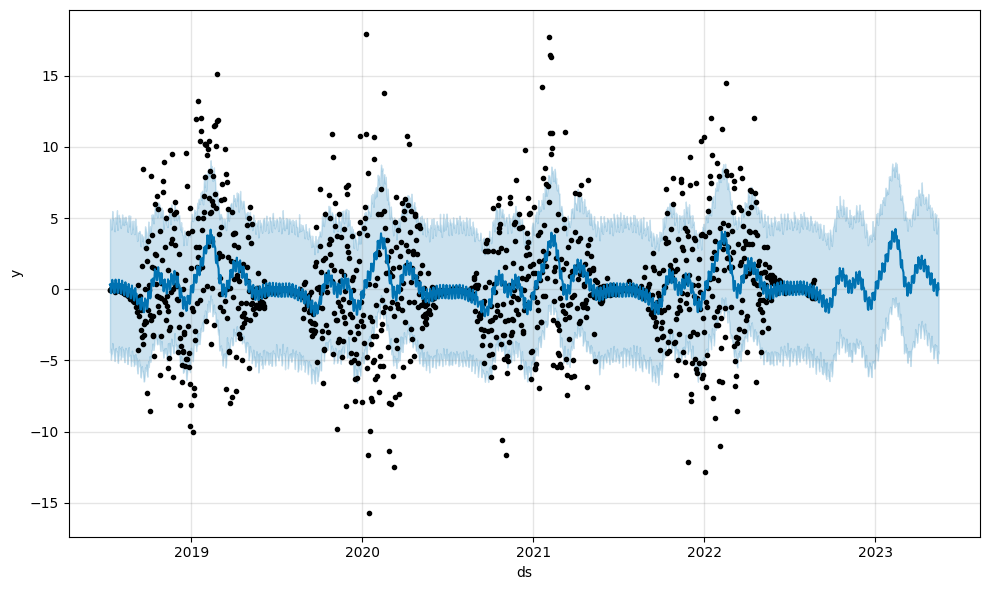

In [758]:
fig1 = m.plot(forecast)

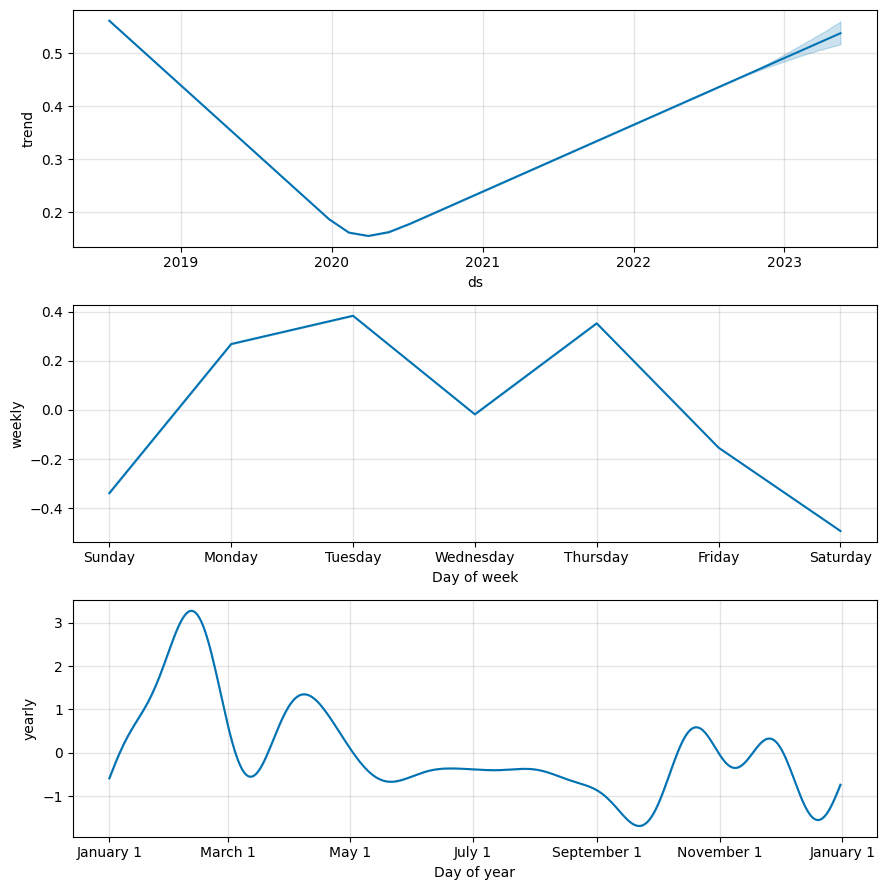

In [759]:
fig2 = m.plot_components(forecast)

In [760]:

forecasted_errors = forecast[['ds', 'yhat']]
forecasted_errors.set_index('ds', inplace=True)

In [761]:
# errors without adjustment
((preds - y) **2).mean()

16.152998744045345

In [762]:
(((preds + forecasted_errors['yhat']) - y)**2).mean()

15.08005812967144

In [763]:
display(preds.tail())

2023-05-12 12:00:00   -1.371556
2023-05-13 12:00:00    0.149294
2023-05-14 12:00:00    0.774887
2023-05-15 12:00:00    1.490469
2023-05-16 12:00:00   -0.183423
dtype: float64

In [764]:
display(y.tail())

2023-05-12 12:00:00    0.378
2023-05-13 12:00:00   -0.801
2023-05-14 12:00:00    0.524
2023-05-15 12:00:00    1.045
2023-05-16 12:00:00   -0.083
Name: ens(9,14), dtype: float64